# Neural Network using PyTorch

In this exercise, you will build a neural network using PyTorch, and apply it to a dataset. Our goal in this exercise is not necessarily to obtain the best results on the dataset. We care more about understanding the different parameters, getting a hands-on experience training networks, and monitoring and debugging them. For this reason, I actually recommend that you don’t use a GPU, and run the code on your local machine, for simpler debugging.


You can get relevant code snippets from [the PyTorch documentation](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) or other sources online. 

## Dataset
We will use the CIFAR-10 dataset.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
%matplotlib inline


In [2]:
BATCH_SIZE = 8
NUM_WORKERS = 4
LOG_DIR = 'runs'

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=NUM_WORKERS)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=NUM_WORKERS)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


First, let's get to know the dataset. Plot a few examples of images and their labels:


plane frog horse dog dog cat cat frog


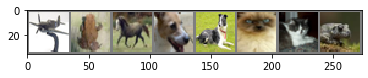

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img * .5 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[j]}' for j in labels))

Display the distribution of images per label.

In [4]:
[print(f'{c} \t {trainset.targets.count(j)}') for j, c in enumerate(classes)];

plane 	 5000
car 	 5000
bird 	 5000
cat 	 5000
deer 	 5000
dog 	 5000
frog 	 5000
horse 	 5000
ship 	 5000
truck 	 5000


Is the data balanced? What effect is imbalanced data expected to have on your model's results? How can you work with imbalanced data?

The data is balanced in this case.  
If the data were not balanced, we could overfit to the more frequent classes (to give an extreme example, if there were only two classes and one class is 90% of the samples, the network may learn to predict the more frequent class in all cases). To work with an imbalanced dataset we can: train using balanced batches (i.e. sample unequally from the data, to create balance during training), compensate for the unbalance by increasing the weight of misclassifications in the less frequent class, or augmenting the data to balance out the dataset (by subsampling from the the less freqent classes). Each method has its weakenesses of course, and different approachs can be tried and even combined.

**NOTE:** It's a good practice when working on Neural Networks to start with a very small dataset and overfit on it. While we don't specifically ask you to do so in the sections below, we recommend that you take this approach, and first write and run your code using easy to use and debug platform, on a small dataset.

## Build your own CNN classifier
In this section, you will develop your own CNN classifier.

This is meant as an opportunity to get more experience building your own NN architectures using PyTorch, and our focus is on making sure you rewrite and review the needed code and not on obtaining optimal performance. That being said, within the limits of the time you have, try to come up with a NN architecture and hyperparameters that would achieve nice results on the dataset.  
We do recommend that you keep this to only 3-4 Conv layers and 1-2 fully connected layers.

If you want a starting point, you can create this network:

```
Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
```

When training the network, use the Adam optimizer.

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


device = "cuda" if torch.cuda.is_available() else "cpu"

def initialize_net(cnn, lr=0.001, device='cpu', seed=42):
    torch.manual_seed(seed)
    if device == 'cuda':
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


    net = cnn().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    return net, criterion, optimizer


In [6]:
class Net(nn.Module):
    def __init__(self, 
                 out_conv1=32, 
                 out_conv2=64, 
                 out_conv3=128, 
                 out_fc1=256, 
                 out_fc2=128):
        
        super(Net, self).__init__()
        
        self.out_conv1 = out_conv1
        self.out_conv2 = out_conv2
        self.out_conv3 = out_conv3
        
        self.out_fc1 = out_fc1
        self.out_fc2 = out_fc2
        
        
        self.conv1 = nn.Conv2d(in_channels=3, 
                               out_channels=self.out_conv1, 
                               kernel_size=3, 
                               padding=1)
        
        self.conv2 = nn.Conv2d(in_channels=self.out_conv1, 
                               out_channels=self.out_conv2, 
                               kernel_size=3, 
                               padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=self.out_conv2, 
                               out_channels=self.out_conv3, 
                               kernel_size=3, 
                               padding=1)
        
        self.fc1 = nn.Linear(in_features=self.out_conv3 * 4 * 4, 
                             out_features=self.out_fc1)  
        # 4 = input_dimension / (pool_size ^ pooling_operations) = 
        # = 32 / 2 ^ 3 = 32 / 8 = 4
        
        self.fc2 = nn.Linear(in_features=self.out_fc1, 
                             out_features=self.out_fc2)
        
        self.fc3 = nn.Linear(in_features=self.out_fc2, 
                             out_features=10)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = F.relu
        
        
    def forward(self, x):
        
        self.activation = self.conv1(x)
        out = self.pool(self.relu(self.activation))
        out = self.pool(self.relu(self.conv2(out)))
        out = self.pool(self.relu(self.conv3(out)))
        
        out = out.view(out.shape[0], -1)
        
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        
        return out
        

As suggested, we'll first start with a small training set (and overfit it), to verify that everything works. 

In [7]:
basic_net, criterion, optimizer = initialize_net(Net, device=device)

dataiter = iter(testloader)
n_batches = 25
n_epochs = 40
x, y = [], []

for _ in range(n_batches):
    images, labels = dataiter.next()
    x.append(images)
    y.append(labels)

In [8]:
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.
    for i in range(n_batches):
        # get the inputs; data is a list of [inputs, labels]
        xi, yi = x[i].to(device), y[i].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = basic_net(xi)
        loss = criterion(outputs, yi)
        loss.backward()
        optimizer.step()

        
        running_loss += loss.item()
    # print statistics
    print(f'epoch: {epoch + 1}\t loss:{running_loss / n_batches:.3f}')

print('Finished Training')

epoch: 1	 loss:2.305
epoch: 2	 loss:2.198
epoch: 3	 loss:2.059
epoch: 4	 loss:1.979
epoch: 5	 loss:1.908
epoch: 6	 loss:1.877
epoch: 7	 loss:1.845
epoch: 8	 loss:1.711
epoch: 9	 loss:1.529
epoch: 10	 loss:1.361
epoch: 11	 loss:1.192
epoch: 12	 loss:1.051
epoch: 13	 loss:0.913
epoch: 14	 loss:0.693
epoch: 15	 loss:0.665
epoch: 16	 loss:0.620
epoch: 17	 loss:0.526
epoch: 18	 loss:0.365
epoch: 19	 loss:0.338
epoch: 20	 loss:0.208
epoch: 21	 loss:0.169
epoch: 22	 loss:0.078
epoch: 23	 loss:0.036
epoch: 24	 loss:0.029
epoch: 25	 loss:0.019
epoch: 26	 loss:0.006
epoch: 27	 loss:0.003
epoch: 28	 loss:0.002
epoch: 29	 loss:0.002
epoch: 30	 loss:0.001
epoch: 31	 loss:0.001
epoch: 32	 loss:0.001
epoch: 33	 loss:0.001
epoch: 34	 loss:0.001
epoch: 35	 loss:0.001
epoch: 36	 loss:0.001
epoch: 37	 loss:0.000
epoch: 38	 loss:0.000
epoch: 39	 loss:0.000
epoch: 40	 loss:0.000
Finished Training


GroundTruth:  cat ship ship plane frog frog car frog
Predicted:    cat ship ship plane frog frog car frog


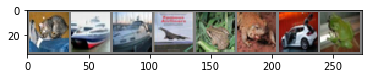

In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()
outputs = basic_net(images.to(device))
_, predicted = torch.max(outputs, 1)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[j]}' for j in labels))
print('Predicted:   ', ' '.join(f'{classes[j]}' for j in predicted))

In [10]:
def evaluate_net(net):

    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == labels.to(device)).squeeze()

            for i in range(BATCH_SIZE):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    [print(f'Accuracy of {c}: \t {100 * class_correct[j] / class_total[j]}%') 
     for j, c in enumerate(classes)];

    print('\nAccuracy of the network on the 10000 test images:',  
          f'{100 * np.sum(class_correct) / np.sum(class_total)}%')



In [11]:
evaluate_net(basic_net)

Accuracy of plane: 	 35.9%
Accuracy of car: 	 23.6%
Accuracy of bird: 	 27.1%
Accuracy of cat: 	 22.4%
Accuracy of deer: 	 17.6%
Accuracy of dog: 	 18.8%
Accuracy of frog: 	 42.9%
Accuracy of horse: 	 17.6%
Accuracy of ship: 	 48.4%
Accuracy of truck: 	 36.1%

Accuracy of the network on the 10000 test images: 29.04%


As we can see, although there is poor accuracy on the test set, our basic network that was trained is able to overfit a small portion of the training set and the training loss is almost zero.

Now we can proceed..  


## Tensorboard
TensorBoard provides visualization and tooling for machine learning experimentation:
- Tracking and visualizing metrics such as loss and accuracy
- Visualizing the model graph (ops and layers)
- Viewing histograms of weights, biases, or other tensors as they change over time
- Projecting embeddings to a lower dimensional space
- Displaying images, text, and audio data
- Profiling programs

Tensorboard worked originally with Tensorflow but can now be used with PyTorch as well.  
You can embed a tensorboard widget in a Jupyter Notebook, although if you're not using Google Colab we recommend that you open tensorboard separately.

To get started with Tensorboard, please read the following pages:

PyTorch related:
1. https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html
1. https://becominghuman.ai/logging-in-tensorboard-with-pytorch-or-any-other-library-c549163dee9e
1. https://towardsdatascience.com/https-medium-com-dinber19-take-a-deeper-look-at-your-pytorch-model-with-the-new-tensorboard-built-in-513969cf6a72
1. https://pytorch.org/docs/stable/tensorboard.html
1. https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/04-utils/tensorboard

Tensorflow related:
1. https://itnext.io/how-to-use-tensorboard-5d82f8654496
1. https://www.datacamp.com/community/tutorials/tensorboard-tutorial
1. https://medium.com/@anthony_sarkis/tensorboard-quick-start-in-5-minutes-e3ec69f673af
1. https://www.guru99.com/tensorboard-tutorial.html
1. https://www.youtube.com/watch?time_continue=1&v=s-lHP8v9qzY&feature=emb_logo
1. https://www.youtube.com/watch?v=pSexXMdruFM


### Starting Tensorboard
Jupyter Notebook has extensions for displaying TensorBoard inside the notebook. Still, I recommend that you run it separately, as it tends to get stuck in notebooks.

The syntax to load TensorBoard in a notebook is this:
```python
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir ./logs
```

In the shell, you can instead run:
```
tensorboard --logdir ./logs
```

In [13]:
from torch.utils.tensorboard import SummaryWriter

writer_basic = SummaryWriter(f'./{LOG_DIR}/basic_net/')

### Show images using TensorBoard

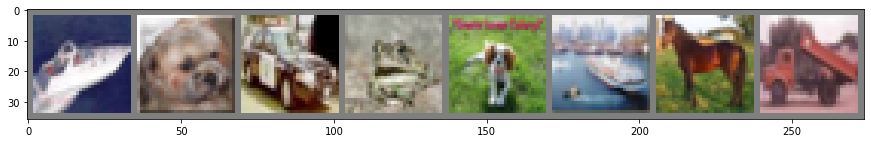

In [14]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)
fig = plt.figure(figsize=(15, 12))
# show images
imshow(img_grid)

# write to tensorboard
writer_basic.add_image('example_images', img_grid)
writer_basic.flush()

### TensorBoard ScreenShot
<div>
    <img src='./screenshots/example_images.png'/>
<div/>
    
We haven’t figured out yet why our sample images are distorted when uploaded to tensorboard.  
Any hints?

Running the following command from the relevant directory in the command line will open Tensorboard at  localhost:6006:
```
tensorboard --logdir=runs
```
And the images will be displayed there.

### Inspect the model graph
You can print a network object to find useful information about it:

In [15]:
print(basic_net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


TensorBoard can help visualize the network graph. It takes practice to read these.  

Write the graph to TensorBoard and review it.

In [16]:
writer_basic.add_graph(basic_net, images.to(device))
writer_basic.flush()
writer_basic.close()

### TensorBoard Graph

<div>
    <img src='./screenshots/network_graph.png'/>
<div/>

You can also use the package `torchsummary` for a fuller info on the model:

In [16]:
# !pip install torchsummary

In [17]:
channels=3; H=32; W=32
from torchsummary import summary
summary(basic_net, input_size=(channels, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
         MaxPool2d-2           [-1, 32, 16, 16]               0
            Conv2d-3           [-1, 64, 16, 16]          18,496
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 8, 8]          73,856
         MaxPool2d-6            [-1, 128, 4, 4]               0
            Linear-7                  [-1, 256]         524,544
            Linear-8                  [-1, 128]          32,896
            Linear-9                   [-1, 10]           1,290
Total params: 651,978
Trainable params: 651,978
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.55
Params size (MB): 2.49
Estimated Total Size (MB): 3.05
-------------------------------------------

## Train the network
Next, we'll train the network. In the training loop, log relevant metrics that would allow you to plot in TensorBoard:

1. The network loss
1. Train and test error
1. Average weight in the first layer
1. Histogram of weights in the first layer

In [18]:
def train_nn(net, crit, opt, writer, n_epochs=8, every_n_iter=1000, return_activation=True, loder=trainloader):
    step = 0

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_accuracy = 0.0
        running_avg_weights = 0.0

        for i, train_data in enumerate(loder):
            inputs, labels = train_data[0].to(device), train_data[1].to(device) 

            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
#             if return_activation:
#                 outputs, activation = outputs
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Compute accuracy
            _, predictions = torch.max(outputs, 1)
            accuracy = (labels == predictions.squeeze()).float().mean()

            running_accuracy += accuracy.item()
            running_loss += loss.item()
            running_avg_weights += torch.mean(net.conv1.weight.data)


            if (i % every_n_iter) == (every_n_iter - 1):    # every 2000 mini-batches...
                print(f'epoch: {epoch + 1}\t iter: {i + 1}\t loss:{running_loss / every_n_iter:.5f}')
                #calculate the test error
                running_test_accuracy = 0.0

                net.eval()

                with torch.no_grad():
                    for test_data in testloader:
                        test_images, test_labels = test_data[0].to(device), test_data[1].to(device) 
                        test_outputs = net(test_images)
                        _, test_pred = torch.max(test_outputs, 1)
                        test_accuracy = (test_labels == test_pred.squeeze()).float().mean()
                        running_test_accuracy += test_accuracy.item()

                net.train()

                # ...log the running loss
                writer.add_scalar('loss/training',
                                  running_loss / every_n_iter,
                                  epoch * len(trainloader) + i)

                # ...log the running accuracy
                writer.add_scalar('error/training',
                                  1 - (running_accuracy / every_n_iter),
                                  epoch * len(trainloader) + i)

                # ...log the running test accuracy
                writer.add_scalar('error/test',
                                  1 - (running_test_accuracy / len(testloader)),
                                  epoch * len(trainloader) + i)

                # ...log the running average weights in layer 1
                writer.add_scalar('Average weights in layer 1',
                                  running_avg_weights / every_n_iter,
                                  epoch * len(trainloader) + i)

                # ...log the histogram of the weights in layer 1
                writer.add_histogram('Layer 1 weights', 
                                     net.conv1.weight.data, 
                                     step, bins='auto')

                if return_activation:
                    writer.add_histogram('Layer 1 activations', 
                                         net.activation.detach().to('cpu').numpy(), 
                                         step, bins='auto')


                step += 1
                running_loss = 0.0
                running_accuracy = 0.0
                running_avg_weights = 0.0

    print('Finished Training')

    writer.flush()
    writer.close()


In [19]:
writer_main = SummaryWriter(f'./{LOG_DIR}/main_net/') 
main_net, criterion, optimizer = initialize_net(Net, device=device)
writer_main.add_graph(main_net, images.to(device))
train_nn(main_net, criterion, optimizer, writer_main)
print()
evaluate_net(main_net)

epoch: 1	 iter: 1000	 loss:1.84938
epoch: 1	 iter: 2000	 loss:1.48573
epoch: 1	 iter: 3000	 loss:1.33485
epoch: 1	 iter: 4000	 loss:1.23905
epoch: 1	 iter: 5000	 loss:1.13990
epoch: 1	 iter: 6000	 loss:1.05757
epoch: 2	 iter: 1000	 loss:0.95971
epoch: 2	 iter: 2000	 loss:0.95023
epoch: 2	 iter: 3000	 loss:0.96776
epoch: 2	 iter: 4000	 loss:0.90382
epoch: 2	 iter: 5000	 loss:0.90145
epoch: 2	 iter: 6000	 loss:0.88631
epoch: 3	 iter: 1000	 loss:0.75949
epoch: 3	 iter: 2000	 loss:0.76080
epoch: 3	 iter: 3000	 loss:0.77311
epoch: 3	 iter: 4000	 loss:0.77052
epoch: 3	 iter: 5000	 loss:0.77547
epoch: 3	 iter: 6000	 loss:0.77601
epoch: 4	 iter: 1000	 loss:0.64559
epoch: 4	 iter: 2000	 loss:0.65068
epoch: 4	 iter: 3000	 loss:0.65609
epoch: 4	 iter: 4000	 loss:0.68298
epoch: 4	 iter: 5000	 loss:0.66254
epoch: 4	 iter: 6000	 loss:0.69853
epoch: 5	 iter: 1000	 loss:0.56214
epoch: 5	 iter: 2000	 loss:0.56921
epoch: 5	 iter: 3000	 loss:0.59254
epoch: 5	 iter: 4000	 loss:0.60041
epoch: 5	 iter: 5000

#### 1. The network loss
<div>
<img src='./screenshots/loss_main.png' width=250/>
</div>

#### 2. Test and training error
<div>
<img src='./screenshots/errors_main.png'width=500/>
</div>

#### 3&4. Average weight & Histogram of weights in the first layer
<div>
<img src='./screenshots/mean_W_L1.png' width=250/>
<img src='./screenshots/W_hist.png' width=250/>
</div>

### Precision-Recall Curve
Use TensorBoard to plot the precision-recall curve:

In [20]:
def add_pr_curve_tensorboard(writer, class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]
    
    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

main_net.eval()

class_probs = []
class_preds = []
with torch.no_grad():
    for images, _ in testloader:

        output = main_net(images.to(device))
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(writer_main, i, test_probs, test_preds)

<div>
    <img src='./screenshots/pr_bird.png' width="300"/>
    <img src='./screenshots/pr_car.png' width="300"/>
</div>
<div>
    <img src='./screenshots/pr_cat.png' width="300"/>
    <img src='./screenshots/pr_deer.png' width="300"/>
</div>
<div>
    <img src='./screenshots/pr_dog.png' width="300"/>
    <img src='./screenshots/pr_frog.png' width="300"/>
</div> 
<div>
    <img src='./screenshots/pr_horse.png' width="300"/>
    <img src='./screenshots/pr_plane.png' width="300"/>
</div> 
<div>
    <img src='./screenshots/pr_ship.png' width="300"/>
    <img src='./screenshots/pr_truck.png' width="300"/>
</div>


### Display Model Errors
A valuable practice is to review errors made by the model in the test set. These might reveal cases of bad preprocessing or lead to come up with improvements to your original model.

Show 12 images of errors made by the model. For each, display the true and predicted classes, and the model confidence in its answer.

In [21]:
def plot_classes_preds(images, labels, preds, probs, rows=3, cols=4):
    '''
    Generates matplotlib Figure of images and labels from a batch, 
    that shows the network's top prediction along with its probability, 
    alongside the actual label, coloring this information based on whether 
    the prediction was correct or not.
    '''
    # plot the images in the batch, along with predicted and true labels
#     print(type(classes))
    fig = plt.figure(figsize=(15, 12))
    for idx, img in enumerate(images):
        ax = fig.add_subplot(rows, cols, idx+1, xticks=[], yticks=[])
        
        imshow(transform(img))
        
        ax.set_title(f"prediction: {classes[preds[idx]]}\n" + 
                     f"confidence: {probs[idx,preds[idx]] * 100:.1f}%\n" +
                     f"true label: {classes[labels[idx]]}", 
                     color=("green" if preds[idx]==labels[idx] else "red"), 
                     fontsize=20)
    fig.tight_layout()
    
    return fig


n = 12

mask_mistakes = np.argwhere(np.array(test_preds.tolist())!=np.array(testset.targets))
mask_mistakes = mask_mistakes[:n].flatten()

inputs = testset.data[mask_mistakes]
labels = np.array(testset.targets)[mask_mistakes]
probs = test_probs[mask_mistakes, :]
preds = test_preds[mask_mistakes]

fig = plot_classes_preds(inputs, labels, preds, probs)
writer_main.add_figure('predictions vs. actuals', fig)
writer_main.flush()

#### Model Errors
<div>
    <img src='./screenshots/model_errors.png'/>
<div/>

## Batch Normalization
In this section, we'll add a Batch Norm layer to your network.  
Use TensorBoard to compare the network's convergence (train and validation loss) with and without Batch Normalization.


In [22]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class BatchNormNet(nn.Module):
    def __init__(self, 
                 out_conv1=32, 
                 out_conv2=64, 
                 out_conv3=128, 
                 out_fc1=256, 
                 out_fc2=128):
        
        super(BatchNormNet, self).__init__()
        
        self.out_conv1 = out_conv1
        self.out_conv2 = out_conv2
        self.out_conv3 = out_conv3
        
        self.out_fc1 = out_fc1
        self.out_fc2 = out_fc2
        
        
        self.conv1 = nn.Conv2d(in_channels=3, 
                               out_channels=self.out_conv1, 
                               kernel_size=3, 
                               padding=1)
        
        self.conv1_bn = nn.BatchNorm2d(self.out_conv1)
        
        self.conv2 = nn.Conv2d(in_channels=self.out_conv1, 
                               out_channels=self.out_conv2, 
                               kernel_size=3, 
                               padding=1)
        
        self.conv2_bn = nn.BatchNorm2d(self.out_conv2)
        
        self.conv3 = nn.Conv2d(in_channels=self.out_conv2, 
                               out_channels=self.out_conv3, 
                               kernel_size=3, 
                               padding=1)
        
        self.conv3_bn = nn.BatchNorm2d(self.out_conv3)
        
        self.fc1 = nn.Linear(in_features=self.out_conv3 * 4 * 4, 
                             out_features=self.out_fc1)  
        # 4 = input_dimension / (pool_size ^ pooling_operations) = 
        # = 32 / 2 ^ 3 = 32 / 8 = 4
        
        self.fc1_bn = nn.BatchNorm1d(self.out_fc1)
        
        self.fc2 = nn.Linear(in_features=self.out_fc1, 
                             out_features=self.out_fc2)
        
        self.fc2_bn = nn.BatchNorm1d(self.out_fc2)
        
        self.fc3 = nn.Linear(in_features=self.out_fc2, 
                             out_features=10)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = F.relu
        
        
    def forward(self, x):
        
        self.activation = self.conv1_bn(self.conv1(x))
        out = self.pool(self.relu(self.activation))
        out = self.pool(self.relu(self.conv2_bn(self.conv2(out))))
        out = self.pool(self.relu(self.conv3_bn(self.conv3(out))))
        
        out = out.view(out.shape[0], -1)

        out = self.relu(self.fc1_bn(self.fc1(out)))
        out = self.relu(self.fc2_bn(self.fc2(out)))
        out = self.fc3(out)
        
        return out
        

In [23]:
writer_bn = SummaryWriter(f'./{LOG_DIR}/batchNorm/') 
net_bn, criterion, optimizer = initialize_net(BatchNormNet, device=device)
writer_bn.add_graph(net_bn, images.to(device))
train_nn(net_bn, criterion, optimizer, writer_bn)
print()
evaluate_net(net_bn)

epoch: 1	 iter: 1000	 loss:1.69159
epoch: 1	 iter: 2000	 loss:1.42955
epoch: 1	 iter: 3000	 loss:1.28736
epoch: 1	 iter: 4000	 loss:1.23197
epoch: 1	 iter: 5000	 loss:1.14333
epoch: 1	 iter: 6000	 loss:1.10202
epoch: 2	 iter: 1000	 loss:1.02017
epoch: 2	 iter: 2000	 loss:1.00259
epoch: 2	 iter: 3000	 loss:1.00765
epoch: 2	 iter: 4000	 loss:0.95188
epoch: 2	 iter: 5000	 loss:0.93637
epoch: 2	 iter: 6000	 loss:0.93623
epoch: 3	 iter: 1000	 loss:0.84908
epoch: 3	 iter: 2000	 loss:0.84845
epoch: 3	 iter: 3000	 loss:0.83125
epoch: 3	 iter: 4000	 loss:0.82862
epoch: 3	 iter: 5000	 loss:0.83867
epoch: 3	 iter: 6000	 loss:0.82649
epoch: 4	 iter: 1000	 loss:0.73382
epoch: 4	 iter: 2000	 loss:0.70073
epoch: 4	 iter: 3000	 loss:0.73130
epoch: 4	 iter: 4000	 loss:0.72122
epoch: 4	 iter: 5000	 loss:0.71101
epoch: 4	 iter: 6000	 loss:0.73817
epoch: 5	 iter: 1000	 loss:0.64156
epoch: 5	 iter: 2000	 loss:0.62665
epoch: 5	 iter: 3000	 loss:0.64489
epoch: 5	 iter: 4000	 loss:0.64753
epoch: 5	 iter: 5000

Use TensorBoard to plot the distribution of activations with and without Batch Normalization.

#### Activations
<div>
    <img src='./screenshots/L1_activations.png' width=500/>
<div/>
As expected, the input of the first activation layer is centered and normalized  

#### Loss & Errors
<div>
    <img src='./screenshots/train_losses_main_vs_bn.png' width=250/>
<div/>
<div>
    <img src='./screenshots/errors_main_vs_bn.png' width=500/>
<div/>

The loss and train error of the model with the batch_norm layers (in red) is slightly worse than the loss and error of the model without the batch_norm (blue). The test error however, is in the opposite direction. This suggest that Batch_norm can help reduce over fitting and enhance performance of convolutional neural network.

## Data Augmentation
Augmenting the data is a useful trick to increase the size of the training set and reduce the generalization error.  

Useful resources: 
- [Explanation about augmentation](https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/)
- The [torchvision transforms documentation](https://pytorch.org/docs/stable/torchvision/transforms.html)
- The [albumentations](https://github.com/albumentations-team/albumentations) repo

Try to think which transformation can be useful for data augmentation for our task?

Since out data contains mostly centered, naturalistic images, some of the most useful transformation may be introducing horizontal flips, adding noise or blurring images, as well as image rotation, shearing scaling and shifting.

Apply 1 or 2 basic transformations and check how they affect the network's performance:

In [35]:
transform_aug = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(20),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset_aug = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_aug)

trainloader_aug = torch.utils.data.DataLoader(trainset_aug, batch_size=BATCH_SIZE,
                                              shuffle=True, num_workers=2)

Files already downloaded and verified


In [25]:
writer_aug = SummaryWriter(f'./{LOG_DIR}/augmentation')
net_aug, criterion, optimizer = initialize_net(Net, device=device)
train_nn(net_aug, criterion, optimizer, writer_aug, n_epochs=16, loder=trainloader_aug)
print()
evaluate_net(net_aug)

epoch: 1	 iter: 1000	 loss:1.90637
epoch: 1	 iter: 2000	 loss:1.58399
epoch: 1	 iter: 3000	 loss:1.45595
epoch: 1	 iter: 4000	 loss:1.39155
epoch: 1	 iter: 5000	 loss:1.31703
epoch: 1	 iter: 6000	 loss:1.26596
epoch: 2	 iter: 1000	 loss:1.19910
epoch: 2	 iter: 2000	 loss:1.16480
epoch: 2	 iter: 3000	 loss:1.17786
epoch: 2	 iter: 4000	 loss:1.11994
epoch: 2	 iter: 5000	 loss:1.10850
epoch: 2	 iter: 6000	 loss:1.08944
epoch: 3	 iter: 1000	 loss:1.03988
epoch: 3	 iter: 2000	 loss:1.02852
epoch: 3	 iter: 3000	 loss:1.02458
epoch: 3	 iter: 4000	 loss:1.00976
epoch: 3	 iter: 5000	 loss:1.01222
epoch: 3	 iter: 6000	 loss:1.02607
epoch: 4	 iter: 1000	 loss:0.97244
epoch: 4	 iter: 2000	 loss:0.94880
epoch: 4	 iter: 3000	 loss:0.96656
epoch: 4	 iter: 4000	 loss:0.97462
epoch: 4	 iter: 5000	 loss:0.92700
epoch: 4	 iter: 6000	 loss:0.95921
epoch: 5	 iter: 1000	 loss:0.93221
epoch: 5	 iter: 2000	 loss:0.91199
epoch: 5	 iter: 3000	 loss:0.92879
epoch: 5	 iter: 4000	 loss:0.91547
epoch: 5	 iter: 5000

#### Loss
<div>
    <img src='./screenshots/loss_main_vs_aug.png' width=250/>
<div/>

#### Errors
<div>
    <img src='./screenshots/errors_main_vs_aug.png' width=500/>
<div/>
    
While the loss and train error of the non-augmented model (in blue) keeps improving it seems that the test error has already saturated.  
Further training would probably overfit the train data.  
On the other hand, the loss of the model trained on the augmented data (light blue) is larger than the loss of the basic model but the test error is still decreasing.  
If we would have trained for more epochs it would probably outperform the basic model.


## Transfer learning using a NN pre-trained on ImageNet
In this section, we will use a pretrained network and build a classifier using it to predict the labels of our task.

You might find these resources useful:
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce
- https://www.analyticsvidhya.com/blog/2019/10/how-to-master-transfer-learning-using-pytorch/
- https://heartbeat.fritz.ai/transfer-learning-with-pytorch-cfcb69016c72

### Use a frozen pre-trained network
Use a VGG-16 network, including its weights pretrained on ImageNet.  
Use the pretrained network to obtain the distributed representation in the final layer (the one before the output softmax layer). Freeze the network weights, and add 2 fully connected layers on top of it to classify the images.

In [57]:
from torchvision import models

model = models.vgg16(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

# show previous classifiers in network
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [58]:
torch.manual_seed(42)
if device == 'cuda':
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Add on classifier
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Linear(256, 10),                   
                      nn.LogSoftmax(dim=1))

for param in model.classifier[6].parameters():
    param.requires_grad = True

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()

# show new model
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
    (3): LogSoftmax()
  )
)

In [59]:
for epoch in range(8):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data_train in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data_train[0].to(device), data_train[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print(f'epoch: {epoch + 1}\t iter: {i + 1}\t loss:{running_loss / 1000:.5f}')
            running_loss = 0.0

print('Finished Training')

epoch: 1	 iter: 1000	 loss:1.96632
epoch: 1	 iter: 2000	 loss:1.52945
epoch: 1	 iter: 3000	 loss:1.38018
epoch: 1	 iter: 4000	 loss:1.33278
epoch: 1	 iter: 5000	 loss:1.30471
epoch: 1	 iter: 6000	 loss:1.27097
epoch: 2	 iter: 1000	 loss:1.23169
epoch: 2	 iter: 2000	 loss:1.21808
epoch: 2	 iter: 3000	 loss:1.21454
epoch: 2	 iter: 4000	 loss:1.21440
epoch: 2	 iter: 5000	 loss:1.19182
epoch: 2	 iter: 6000	 loss:1.19140
epoch: 3	 iter: 1000	 loss:1.17606
epoch: 3	 iter: 2000	 loss:1.15541
epoch: 3	 iter: 3000	 loss:1.16162
epoch: 3	 iter: 4000	 loss:1.17481
epoch: 3	 iter: 5000	 loss:1.15934
epoch: 3	 iter: 6000	 loss:1.15473
epoch: 4	 iter: 1000	 loss:1.13148
epoch: 4	 iter: 2000	 loss:1.13348
epoch: 4	 iter: 3000	 loss:1.14606
epoch: 4	 iter: 4000	 loss:1.15383
epoch: 4	 iter: 5000	 loss:1.14020
epoch: 4	 iter: 6000	 loss:1.13424
epoch: 5	 iter: 1000	 loss:1.12932
epoch: 5	 iter: 2000	 loss:1.12515
epoch: 5	 iter: 3000	 loss:1.11502
epoch: 5	 iter: 4000	 loss:1.12185
epoch: 5	 iter: 5000

In [60]:
evaluate_net(model)

Accuracy of plane: 	 65.0%
Accuracy of car: 	 65.2%
Accuracy of bird: 	 45.3%
Accuracy of cat: 	 45.7%
Accuracy of deer: 	 52.2%
Accuracy of dog: 	 53.1%
Accuracy of frog: 	 71.0%
Accuracy of horse: 	 60.9%
Accuracy of ship: 	 65.8%
Accuracy of truck: 	 66.4%

Accuracy of the network on the 10000 test images: 59.06%


### Fine tuning the weights
In this section, we'll unfreeze the pre-trained weights of the network and allow them to change.  
Be careful - when fine-tuning a network, there is a risk that our attempt to allow the network to adapt to the new domain will lead to a "catastrophic forgetting" of what it had previously learnt.

<div>
    <font color='red' size=5> Please find the solution in the attached notebook 'fine tuning weights'
<div>

## Suggested Resources
1. A good explanation of the different losses - https://gombru.github.io/2019/04/03/ranking_loss/
1. A repo with code implementing CNN classifiers, Siamese networks and Triplet loss with different selection regimes for the MNIST and Fashion-MNIST datasets - https://github.com/adambielski/siamese-triplet
1. There are several resources online for the VGG-Face network (see https://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf), that include pre-trained weights on a face recognition dataset. The weights are here - http://www.robots.ox.ac.uk/~vgg/software/vgg_face/, and PyTorch models are here - http://www.robots.ox.ac.uk/~albanie/pytorch-models.html, and you can also check out https://github.com/prlz77/vgg-face.pytorch and https://github.com/claudio-unipv/vggface-pytorch.